In [263]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

import warnings
warnings.filterwarnings('ignore')

import pysof
import pyema

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
font_size = 15
figsize = (16.0, 8.0)
plt.style.use('ggplot')

def inline():
    """Show inline plots."""
    get_ipython().magic('matplotlib inline')
    matplotlib.rcParams['figure.figsize'] = figsize
    matplotlib.rcParams['font.size'] = font_size

def qt():
    """Show plots in a qt window."""
    get_ipython().magic('matplotlib qt')
    matplotlib.rcParams['figure.figsize'] = figsize
    matplotlib.rcParams['font.size'] = font_size

In [265]:
inline()

# A Hands-on Tutorial on Image-based Identification of Structural Dynamics

## Basic experimental skills

* Camera selection
* Optical components
* Positioning
* Lighting
* Surface preperation
* Acquisiton parameters

Loading the selected video:

In [290]:
filename = r"D:\_Arhiv\_Big data\Činela\cinela4A_S_500slik.cih.cih"
filename = r"D:\_Arhiv\_Big data\Mali_02102018\data\loc_1.cih"
file = '.'.join(filename.split('.')[:-1])
file

'D:\\_Arhiv\\_Big data\\Mali_02102018\\data\\loc_1'

File info:

In [291]:
mraw, info = pysof.load_video(filename)

In [292]:
info

OrderedDict([('Date', '2018/10/2'),
             ('Camera Type', 'FASTCAM SA-Z type 2100K-M-64GB'),
             ('Record Rate(fps)', '200000'),
             ('Shutter Speed(s)', '1/294737'),
             ('Total Frame', '200001'),
             ('Image Width', '1024'),
             ('Image Height', '48'),
             ('Color Bit', '16'),
             ('File Format', 'MRaw'),
             ('EffectiveBit Depth', '12')])

In [293]:
qt()

In [295]:
time = np.linspace(0, 1, int(info['Total Frame']))
fig, ax = plt.subplots(figsize=(17, 5))
def show(i):
    ax.clear()
    ax.imshow(mraw[i], cmap='gray')
    ax.text(10, -10, f'time = {time[i]:5.4f} s')
    ax.text(10, -30, f'frame = {i}')
    ax.grid(False)
    
    axins = zoomed_inset_axes(ax, 3, loc=8)
    axins.imshow(mraw[i, ::-1], cmap='gray')
    axins.set_xlim([165, 220])
    axins.set_ylim([1, 47])
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    axins.grid(False)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="r", lw=2)
    plt.tight_layout()

FuncAnimation(fig, show, frames=np.arange(0, 1000, 100))

In [270]:
inline()

### Acquisition parameters

In [271]:
info

OrderedDict([('Date', '2018/10/2'),
             ('Camera Type', 'FASTCAM SA-Z type 2100K-M-64GB'),
             ('Record Rate(fps)', '200000'),
             ('Shutter Speed(s)', '1/294737'),
             ('Total Frame', '200001'),
             ('Image Width', '1024'),
             ('Image Height', '48'),
             ('Color Bit', '16'),
             ('File Format', 'MRaw'),
             ('EffectiveBit Depth', '12')])

### Optical components, positioning
*Primer slabega fokusa, nepravokotne postavitve*

### Lighting
To optain optimal lighting conditions, histogram of pixel intensity is viewd.

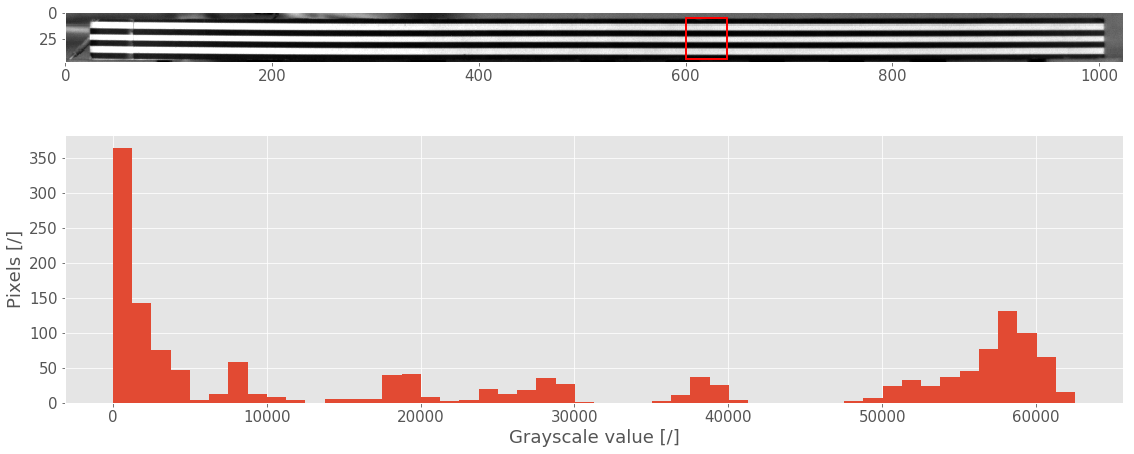

In [272]:
x0, y0, d = 600, 5, 40
roi = mraw[0, y0:y0+d, x0:x0+d]

fig, ax = plt.subplots(2)
ax[0].imshow(mraw[0], cmap='gray')
ax[1].hist(roi.flatten(), bins=50);
# Formating
ax[0].add_patch(patches.Rectangle((x0, y0), d, d, fill=False, color='r', linewidth=2))
ax[0].grid(False)
ax[1].set_xlabel('Grayscale value [/]')
ax[1].set_ylabel('Pixels [/]')
plt.tight_layout()

### Surface preperation
Sufficient gradient is necessary for optical-flow method application.

In [231]:
grad0, grad1 = np.gradient(mraw[0].astype(float))

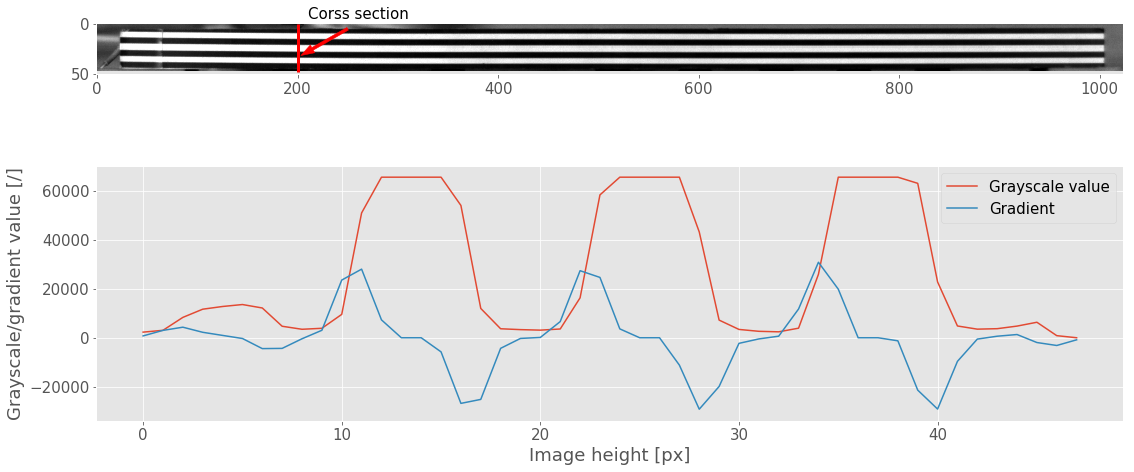

In [232]:
x0 = 200

fig, ax = plt.subplots(2)
ax[0].imshow(mraw[0], cmap='gray')
ax[1].plot(mraw[0, :, x0], label='Grayscale value')
ax[1].plot(grad0[:, x0], label='Gradient')
# Formating
ax[0].vlines(x0, 0, 48, colors='r', linewidth=3)
ax[0].text(x0+10, -5, 'Corss section')
ax[0].arrow(x0+50, 5, -35, 20, color='r', width=3)
ax[0].grid(False)
ax[1].set_xlabel('Image height [px]')
ax[1].set_ylabel('Grayscale/gradient value [/]')
plt.legend()
plt.tight_layout()

## Simplified Optical-flow Method

Basic formulation:
$$
s(x_j,y_k,t)=\frac{I_0(x_j,y_k)-I(x_j,y_k,t)}{|\nabla I_0|}
$$

In [234]:
reference_image = np.average(mraw[:500], axis=0)

In [235]:
grad0, grad1 = np.gradient(reference_image)

Determine points with largest gradient in **vertical** direction.

In [238]:
border = 50
n = 5
N = 20
w = np.arange(border, reference_image.shape[1]-border, np.abs(border - reference_image.shape[1]-border)//N)
h = np.argsort(np.abs(grad0[:, w]), axis=0)[-n:, :].T
inds = np.column_stack((h.flatten(), w.repeat(n)))

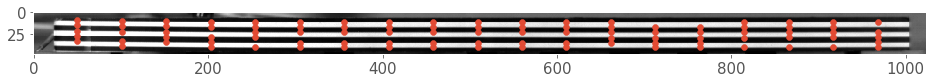

In [273]:
fig, ax = plt.subplots()
ax.imshow(reference_image, cmap='gray')
ax.scatter(inds[:, 1], inds[:, 0])
ax.grid(False)

In [241]:
displacements = pysof.calc_displacements(file, points=inds, n=n)

Show image?(y/n) n



Reshaping for averaging...
Calculating the average...
Shifting the zero of signal...

Displacement identification was successful!
Finished:  2018-12-11 13:13:00.569354


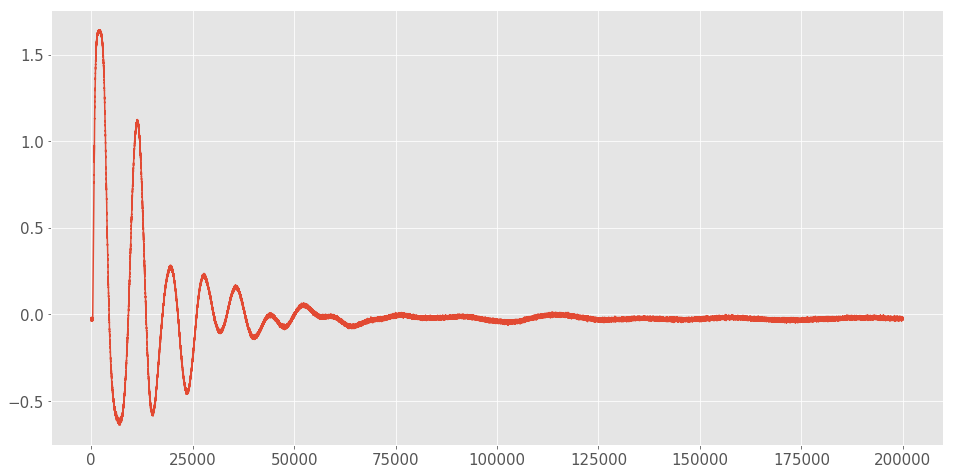

In [282]:
fig, ax = plt.subplots()
ax.plot(displacements[:, 5]);

## Frequency Response Functions

In [243]:
freq, specter = pysof.fft(file, displacements)

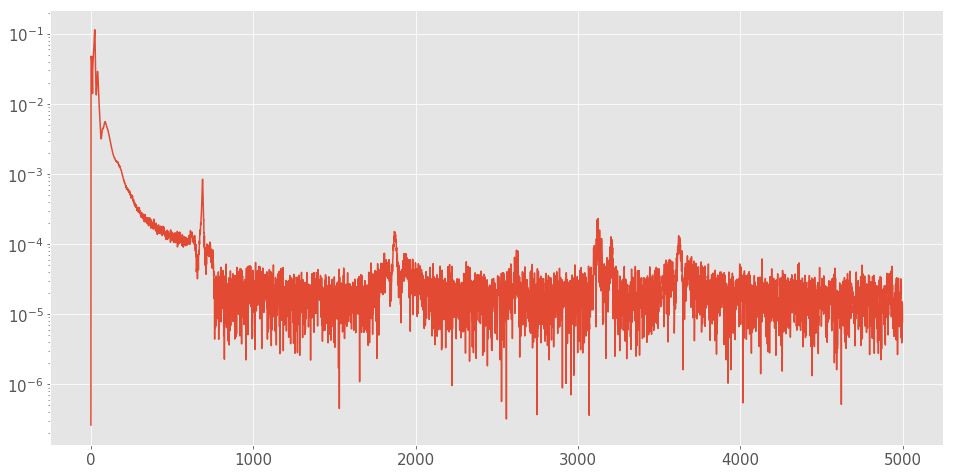

In [244]:
fig, ax = plt.subplots()
ax.semilogy(freq, np.abs(specter[5]));

## Modal Analysis

In [245]:
cam = pyema.lscf(specter, freq)

In [246]:
cam.get_poles()

In [248]:
# cam.stab_chart(cam.all_poles)
approx_nat_freq = [688, 1871, 3623]
cam.identification(approx_nat_freq)

In [308]:
print(f'Natural frequencies: {cam.nat_freq}')
print(f'Damping ratios:      {cam.nat_xi}')

Natural frequencies: [ 687.9055922  1871.8513833  3623.07425906]
Damping ratios:      [0.00037887 0.0016195  0.00092893]


**FRF reconstruction**

In [250]:
frf_rec, modal_const = cam.lsfd(FRF_ind='all')

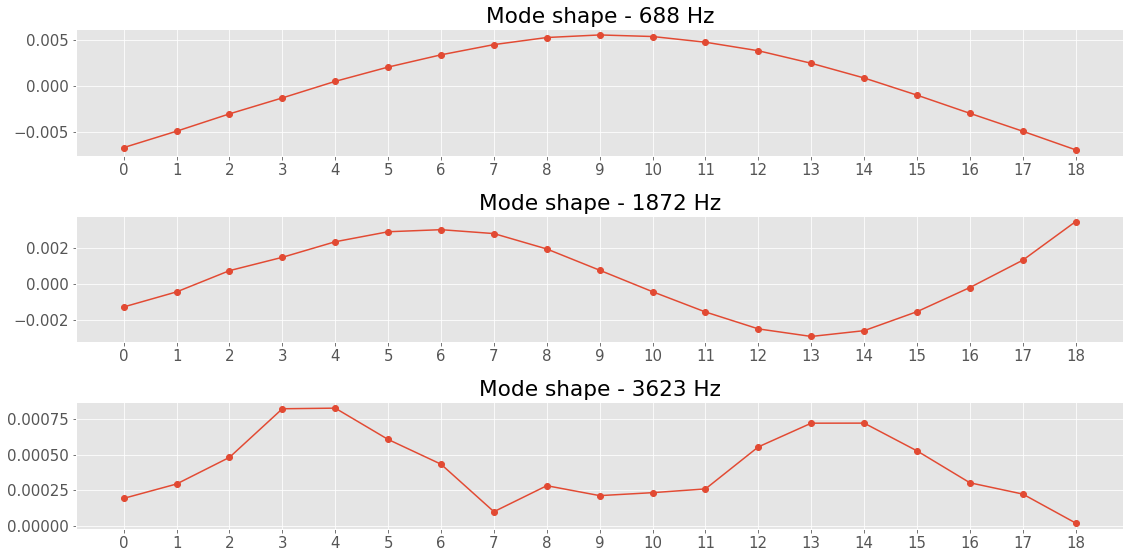

In [306]:
fig, ax = plt.subplots(modal_const.shape[1]-2)
for i, a in enumerate(ax):
    a.plot(modal_const[:, i], 'o-')
    a.set_title(f'Mode shape - {cam.nat_freq[i]:.0f} Hz')
    a.set_xticks(np.arange(modal_const.shape[0]))
plt.tight_layout()

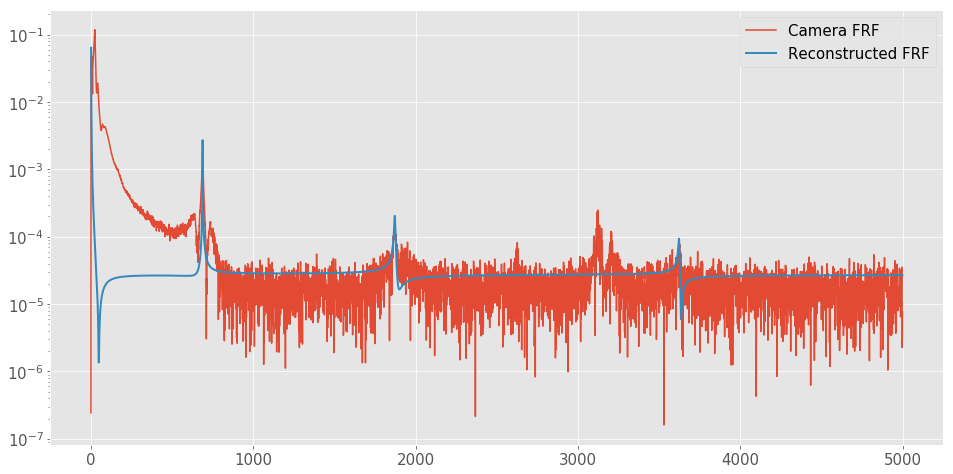

In [307]:
location = 7

fig, ax = plt.subplots()
ax.semilogy(freq, np.abs(specter[location]), label='Camera FRF')
ax.semilogy(freq, np.abs(frf_rec[location]), label='Reconstructed FRF', lw=2)
plt.legend();

## Hybrid method